# 0) Insights Generator for Chat Corpus

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import List, Dict
from aiohttp import web
import json


from insights_generator import util

import insights_generator.core.utils as core_utils
import insights_generator.core.azure_storage_helper as azure_storage_helper
import insights_generator.core.nl_query as nl_query
import insights_generator.core.extract_sentiment_aspects as extract_sentiment_aspects
import insights_generator.core.extract_summary as extract_summary
import insights_generator.core.extract_top_tags as extract_top_tags
import insights_generator.core.extract_statistical_summary as extract_statistical_summary
from insights_generator.core import OAI_client

import insights_generator.core.extract_summary_batched as extract_summary_batched
import insights_generator.core.extract_top_tags as extract_top_tags
import insights_generator.core.parse_reviews as parse_reviews
import insights_generator.core.summarize_parsed_reviews as summarize_parsed_reviews


from pathlib import Path
import logging
import asyncio
import dateutil.parser
from joblib import Parallel, delayed
import itertools
import copy


import os

# Azure OpenAI configurations. This code was run on text-davinci-003
os.environ["AOAI_ENDPOINT"] = "YOUR_AZURE_OPENAI_ENDPOINT_URL"
os.environ["AOAI_KEY"] = "YOUR_KEY"


logger = logging.getLogger("InsightsGenerator")
logger.setLevel(logging.ERROR)


# 1) create a project

The metadata for a project are stored in Azure Storage.
The metadata has the information:
    
1. name - project name
2. productCategory - category, a broad description of the text corpus.
3. productName - name, a description of the text corpus

The chat is broken into chunks of 50 lines and stored as a list of dicts, one dict per chunk. 
The list of dicts is stored in the variable **reviews**, an individual dict is called a **review**. We use the terms review and chunk interchangeably.
The mandatory keys for a review are:

1. **review_text** - stores 50 lines of chat as a string.

    

In [3]:
# Create the project
project_name = "minecraft-1"

project_object = {
    "name" : project_name,
    "productCategory" : "minecraft",
    "productName" : "minecraft"
    }
print("Project metadata:")
print(json.dumps(project_object, indent = 4))

    
# Read in chunked chat data. Each chunk is called a review
reviews_filename = "sample_reviews/minecraft_synthetic_chat_with_numbers_snippets.json"
reviews = core_utils.json_load_from_filename(reviews_filename)

Project metadata:
{
    "name": "minecraft-1",
    "productCategory": "minecraft",
    "productName": "minecraft"
}


# 2) Get Overall Summary of Text Corpus

An overall summary of the text corpus is generated in a batched manner.
Summary of each individual review / chunk is done, then these summaries are combined into an overall summary.
    
Summarization is done in this batched manner for two reasons:
1. To support corpus that is too large for a single prompt
2. To provide a summary for each review/chunk in the corpus. This provides a more nuanced set of summaries
    which are a check against omission of topics in the overall summary.

In [4]:
overall_summary, batch_summaries = extract_summary_batched.summarize_reviews(reviews)
print("\n\nOverall summary of chat:")
print(overall_summary)
print("\n\nBatch summaries:")
print(json.dumps(batch_summaries, indent = 4))

Summarize each chunk of the chat
Starting 4 parallel jobs.
Done


Overall summary of chat:
: Minecraft's latest update has added two new mobs, mooblooms and glow squids, which have been a great addition to the game. Mooblooms provide resources and add a new level of excitement, while glow squids add a new level of exploration. Both creatures are beloved by players.


Batch summaries:
[
    ": Glow squids and mooblooms are awesome additions to Minecraft! They provide unique experiences, resources, and lighting. #glowsquids #mooblooms #minecraft",
    ": People are loving the new mooblooms and glow squids in Minecraft! They are excited to explore the underwater world with the glow squids and use the mooblooms for farming and decorating. Some people prefer the glow squids over the mooblooms, but both mobs are making the game even better.",
    ": Mooblooms and glow squids are the two newest additions to Minecraft and they are both loved by players. Mooblooms provide resources and are cute

# 3) Get the top topics    

We use the terms aspects and topics interchangeably.
1. Aspects are extracted for each review / chunk.
2. The frequency of each aspect across batches is calculated as a frequency score.
3. We retain the top 10 aspects (most frequent).

In [5]:
    
project_object, top_aspects, top_aspects_counts = await extract_top_tags.get_top_aspects_from_reviews(project_object, reviews)
print("Aspect \t | Frequency")
print("_____________________")
for aspect, count in zip(top_aspects, top_aspects_counts):
    print(aspect + "\t| " + str(count))

Extracting sentiment aspects for 4 reviews
Starting 4 parallel extractors
Extracted sentiment aspects for 4 reviews in 14.47550344467163 seconds
Done.
Aspect 	 | Frequency
_____________________
glow squids	| 4
mooblooms	| 4
resources	| 2
wool	| 2
minecraft	| 2
glow squid goals	| 2
farming	| 1
adventure	| 1
must-have	| 1
challenge	| 1


# 4 Generate parsed version of the chat

Parsed version will be used for generating summary with references.
    
We expect the **review_text** to be of the form:
1. Delimited by \n
2. Prefixed by line number (unique across entire chat), Followed by : and then the text of that line


This **review_text** is parsed into a dict. Keys are the line numbers and values are the text of that line.
This **parsed_review_text** is used to look up references.

In [6]:
# Convert review_text to parsed_review_text.
# parsed_review_text is a list of numbered comments. 
parsed_reviews = parse_reviews.parse_reviews(reviews)

# 5) Provide topic summaries with references


## a) Get lines relevant to topic

Given a topic, we ask GPT to generate line numbers for lines relevant to the topic.
By working with line numbers instead of the lines, we avoid hallucinations in retrived lines.
We use the parsed review_text to convert line numbers to line texts.
This is done for each chunk / review and combined to get all relevant lines. We get better performance when we extract lines chunk-by-chunk, rather than the entire corpus.    
    
    
## b) Summarize relevant lines, with references
 
 
Given a topic and lines that are relevant to the topic, extract dominant clusters of lines and summarize each cluster.

We use semantic clustering on relevant lines to get clusters that are:
    1. Semantically highly similar
    2. Have a significant size (number of lines in the cluster > top_cluster_size_threshold)
    
Clusters that satisfy these two properties are called dominant clusters. Dominant clusters capture the major information in the lines. The lines that dont belong to a dominant cluster have one off content and are discarded before summary.

Next, we summarize each dominant cluster and include the lines of that cluster as references for that summary. Since the dominant cluster is quite homogenous, the cluster lines and summary are both quite focussed. The cluster lines serve as reference to the summary or provide related context to it. Further, since the lines were extracted from the corpus via line numbers, they are reproduced verbatim and avoid hallucinations in the references.

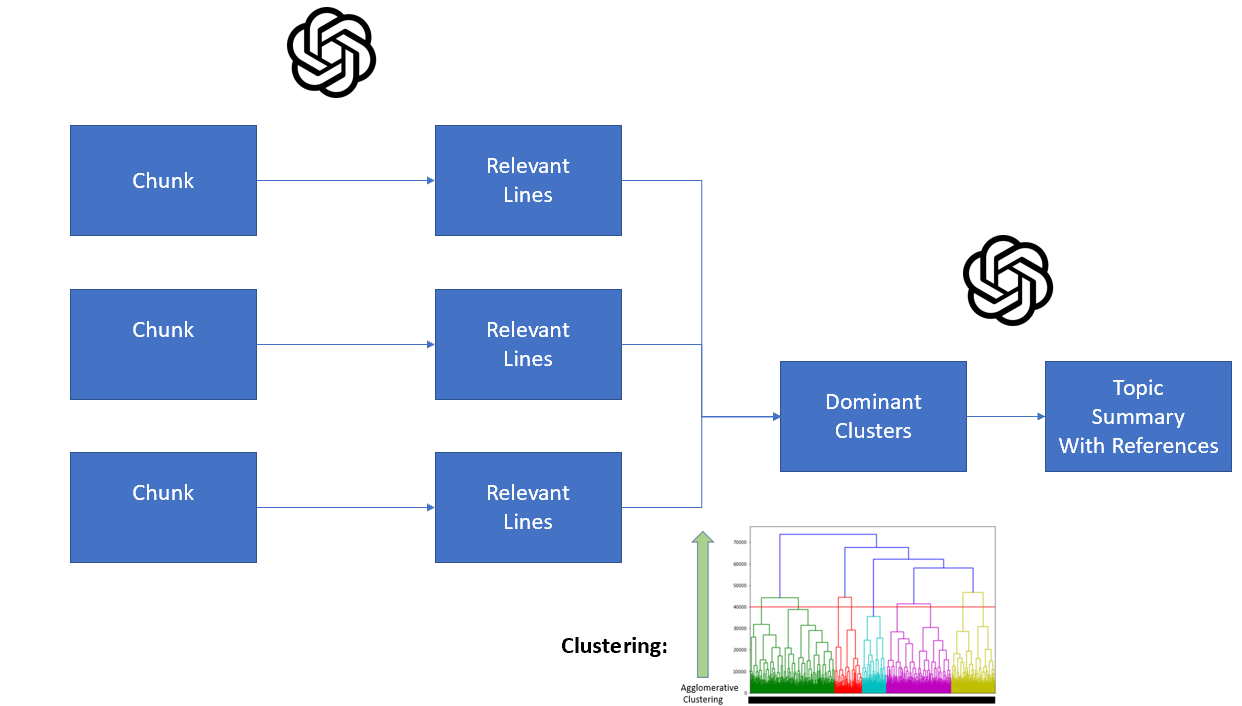

In [7]:
# Deep dive into glow squids
top_cluster_size_threshold = 10
topic = "glow squids"
topic_comments = summarize_parsed_reviews.get_topic_comments(parsed_reviews, topic)
print(len(topic_comments))
topic_summaries_with_references = summarize_parsed_reviews.get_topic_summaries_with_references(topic, topic_comments, top_cluster_size_threshold)
summarize_parsed_reviews.print_topic_summaries_with_references(topic, topic_summaries_with_references)

Getting comments from single reviews...
Starting 4 parallel jobs.
Done.
41
Calculating embeddings...
Starting 4 parallel jobs.
done.
Num clusters: 2
Num top clusters: 1
Topic is: glow squids

Summary with references:

Summary: 

The comments about glow squids in Minecraft are overwhelmingly positive, with users expressing their admiration for the magical creatures and their unique ability to light up the ocean. Many users also expressed their excitement for exploring the underwater world with the glow squids. There were no suggestions to improve glow squids.

References: 

3:"Glow squids are a great addition to the game. They light up the ocean and add a touch of magic 🐙 #glowsquids #minecraftaddict"
5:"Glow squids are just too cute! I love how they change colors and follow me around 🐙 #glowsquids #minecraftlove"
7:"Glow squids are so cool! I love exploring the ocean at night with them by my side 🐙 #glowsquids #minecraftadventure"
11:"Glow squids are the coolest thing in the game! #glo

In [8]:
# Deep dive into moobloom
top_cluster_size_threshold = 10
topic = "moobloom"
topic_comments = summarize_parsed_reviews.get_topic_comments(parsed_reviews, topic)
print(len(topic_comments))
topic_summaries_with_references = summarize_parsed_reviews.get_topic_summaries_with_references(topic, topic_comments, top_cluster_size_threshold)
summarize_parsed_reviews.print_topic_summaries_with_references(topic, topic_summaries_with_references)

Getting comments from single reviews...
Starting 4 parallel jobs.
Done.
16
Calculating embeddings...
Starting 4 parallel jobs.
done.
Num clusters: 2
Num top clusters: 1
Topic is: moobloom

Summary with references:

Summary: 

The comments generally express appreciation for the mooblooms in Minecraft, citing their usefulness for resources such as wool and milk. They also mention how cute and satisfying they are to build with. No suggestions were made to improve moobloom.

References: 

12:"Can we have more mooblooms on servers please? They're so cute and useful 🙏 #moobloom #Minecraft"
13:"I heard mooblooms drop hay blocks now, is that true? #Minecraft #moobloom"
16:"Mooblooms are the best for making wool! #Minecraft #moobloom"
28:Mooblooms make my farm complete! #mooblooms #minecraftfarming
33:I love the mooblooms! They're so cute and provide so much resources! #Mooblooms #MinecraftFTW
40:Loving the mooblooms in Minecraft! So cute and useful! #mooblooms #Minecraft
42:Mooblooms are the b